# Overview
The project needs to give offers on certain diamonds, given historical purchase record. The given data has so many attributes, most of which are categorical variables and a few numerical variables. 
##### The whole processes are as follows:
1. preprocess the data
2. conduct explanatory analysis on both categorical data and numerical data to see their pair relationships
3. analyse the specific attributes with prices and profits to select useful features
4. solve two short questions based on explanatory graphs, k-modes methods as well as simple regression
5. apply one-hot encoding to transform the categorical data and split the data into train-test sets
6. use two statistical models: linear regression and random forest regression to train the data
7. calculate the metrics to determine the significance of the model and calculate the predicted profit from the model
8. use random forest regression model to calculate the offer predicting price
9. use certain rules from previous observations to make offers



## Data Preprocessing
The data given has so many problems and here are what I did:
1. There are so many missing data in 'Cert', 'Depth', 'Fluroescence' and 'Table'. Since Cert has only two certificates with mostly "AGSL", I fill nan with "AGSL". I deleted Depth since I did the research that depth percentage can be calculated by length, width and depth which I have all three of them. For 'Fluroescence' I fill nan with none since there are too many none in this columns. I simply delete the column 'Table'. Keeping this will cause too much bias.
2. 'Measurements' has all strings with different multiply sign. I used regular expression method to parse the three elements and made them new attributes. I also calculated the volume using them.
3. Many columns has blankspace strings. I leave this as one attribute. And also 'Shape' has values like 'Oval' and 'Oval ', which I combines them.
4. Attributes like 'color' have 30 unique values. Sparse values will affect the prediction models thus I transform the values which have less than 0.01 of the dataset to be one category 'other'



In [1]:
get_ipython().magic('matplotlib inline')
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from scipy.stats import mvn
from scipy.integrate import quad
from operator import mul
from functools import reduce
from statistics import mean 
import statsmodels.api as sm
from scipy.optimize import minimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import re
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nbconvert

In [3]:
from sklearn.preprocessing import LabelEncoder

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1, 2, 2, 6])

LabelEncoder()

In [2]:
offer = pd.read_csv("offers.csv")
train = pd.read_csv("training.csv").set_index("id")

In [3]:
#check missing values
train.isna().mean().round(4)*100

Carats                     0.00
Cert                       6.86
Clarity                    0.00
Color                      0.00
Cut                        0.00
Depth                     17.89
Fluroescence              14.29
Known_Conflict_Diamond     0.00
Measurements               0.00
Polish                     0.00
Regions                    0.00
Shape                      0.00
Symmetry                   0.00
Table                     31.44
Vendor                     0.00
Price                      0.00
Retail                     0.00
LogPrice                   0.00
LogRetail                  0.00
dtype: float64

In [4]:
def preprocessing(train):
    train["l"] = [float(re.split(r'[xX+\-*xX]',i)[0]) for i in train["Measurements"]]
    train["w"] = [float(re.split(r'[xX+\-*xX]',i)[1]) for i in train["Measurements"]]
    train["d"] = [float(re.split(r'[xX+\-*xX]',i)[2]) for i in train["Measurements"]]
    train = train.drop(["Table","Measurements","Cut","Known_Conflict_Diamond","Depth"], axis=1)
    try:
        train["LogProfit"] = train["LogRetail"]-train["LogPrice"]
    except:
        pass
    train["NewDepth"] = round(2*train.d/(train.l+train.w)*100,1)
    train["Cert"] = train["Cert"].fillna("AGSL")
    # impute_index = train.loc[train['Fluroescence'].isna()].index
    # impute_prob = train['Fluroescence'].value_counts().values / np.sum(train['Fluroescence'].value_counts().values)
    # impute_vec = np.random.choice(list(train['Fluroescence'].value_counts().index),len(impute_index),p=impute_prob)
    # impute_series = pd.Series(impute_vec, index = impute_index)

    train['Fluroescence'].fillna('None', inplace = True)
    train["volume"] = train.l*train.w*train.d
    train['LogCarats'] = np.log(train.Carats)
    train['Shape']=train[['Shape']].replace(to_replace = 'Oval ', value = 'Oval')

    try:
        train["win"] = np.where(train.LogRetail>train.LogPrice, 1, 0)
    except:
        pass
    
    try:
        train['profit'] = np.exp(train['LogRetail'])-np.exp(train['LogPrice'])
    except:
        pass
    return train

In [5]:
train = preprocessing(train)

In [6]:
def encode_rare(df, name):
    cutoff = 0.01 * len(df)
    counts = df[name].value_counts()
    rare = list(counts.loc[counts < cutoff].index)
    target = ['Others'] * len(rare)
    df[name].replace(to_replace = rare, value = target, inplace = True)
    

columns_with_rare = ['Clarity', 'Color', 'Fluroescence','Shape', 'Symmetry']
for name in columns_with_rare:
    encode_rare(train, name)

## Explanatory Analysis
###  correlation matrix
1. Carats are highly correlated with log price and perfectly correlated with volume. This maybe because bigger diamonds have higher weights. In this sense, for the later part analysis, I only choose Carats as input without measurements or volume.
2. Depth that I calculated is not really correlated with log price which is close to 0, meaning that depth is a variable that not so variate with price.

### boxplots
1. I drew 8 categorical variables onto one panel to show if there would significant difference for some variables.
2. Certificates have similar effect on price. Regions have similar effect on price. But this conclusionis only based on observation.
3. The other attributes are important when model the data since there are differences.

When comparing means of different categorical variables, I did not use rigorous test techniques such as ANOVA test on for example, Regions, to see if their means are significantly different. The reason why I chose not to use is that ignoring these variables would not affect too much on my predicting models 

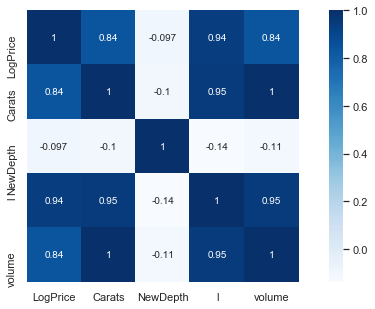

In [7]:
plt.figure(figsize=(11, 5))
correlation = train[['LogPrice','Carats','NewDepth','l', 'volume']].corr()
sns.heatmap(correlation, vmax=1, annot=True, square=True, cmap = "Blues")

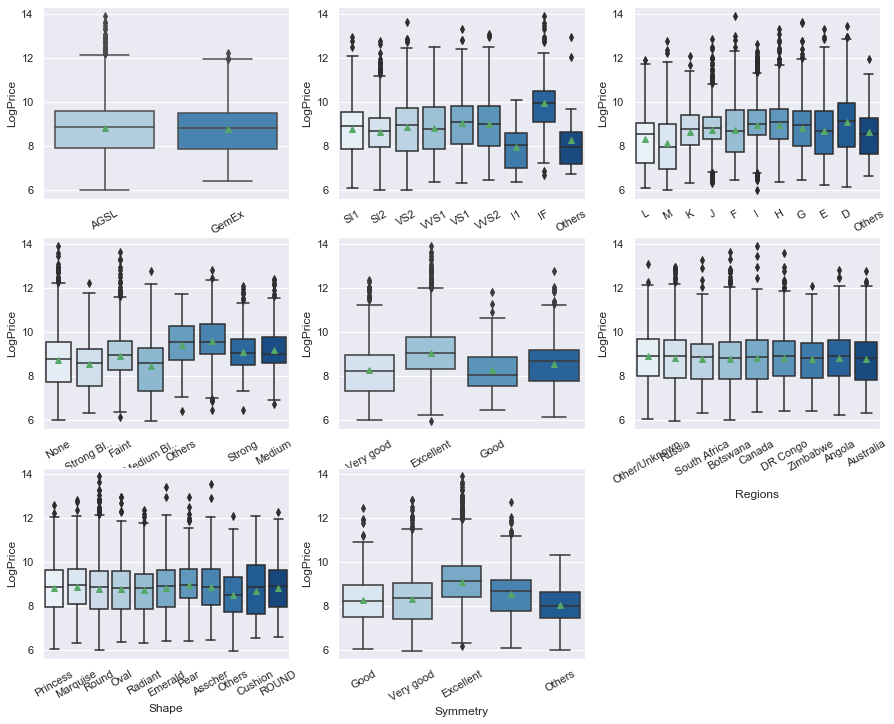

In [8]:
var = ['Cert', 'Clarity', 'Color', 'Fluroescence', 'Polish', 'Regions', 'Shape', 'Symmetry']
plt.figure(figsize=[15,12])
for i in range(1, 9):
    plt.subplot(3,3,i)
    ax = sns.boxplot(x = var[i-1], y = 'LogPrice', data = train, palette='Blues', showmeans=True)
    plt.setp(ax.get_xticklabels(), rotation=30)

## Short problem 1
Do you think that any of the vendors are over or under charging for diamonds compared to the other vendors? Do you think they are selling the same kind of diamonds? How did you come to this conclusion?
### my answer:
I plotted two boxplots of four vendors against the profit and the log return of the diamonds. This shows that the profit of diamonds Vendor1 sells are much lower than Vendor2. This is because Vendor2 sells diamonds with much higher carats diamonds. However, this cannot give us whether they charge higher or not. Below this graph, I plotted the log return of four vendors. As you can see, diamonds from Vendor4 have relatively twice lower return comparing to the other three vendors whose return are similar with one another. In this sense, Vendor4 overly charges the diamonds than the other three vendors.

They are selling different diamonds. I used two methods to obtain this result. Firstly, I plotted the Carats of the diamonds they are selling, which shows Vendor2 sells high carats diamonds whereas Vendor1 sells lower carats diamonds. Secondly, since I do not know the exact label of the diamonds, I wanted to apply unsupervised machine learning to cluster the diamonds based on their categorical variables. K modes calculates the Hamming distance(1998 by Zhehue Huang) for categorical data. The reusult shows that Vendor1 sell 35% of the first kind of diamonds clustered by the model while the other three sells 44%-47% of the first kind. This method is not precise since it uses black box to cluster. But somehow it conforms the observations on the boxplot.


(-20000, 20000)

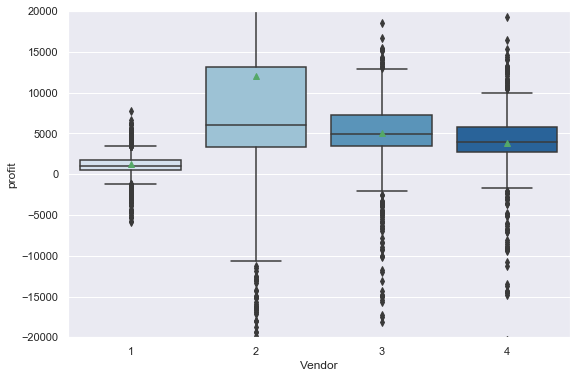

In [9]:
# explanatory analysis on different vendors
plt.figure(figsize=(9, 6))
sns.boxplot(x='Vendor', y='profit', data=train, palette='Blues', showmeans=True)
plt.ylim(-20000, 20000)

(-1, 1)

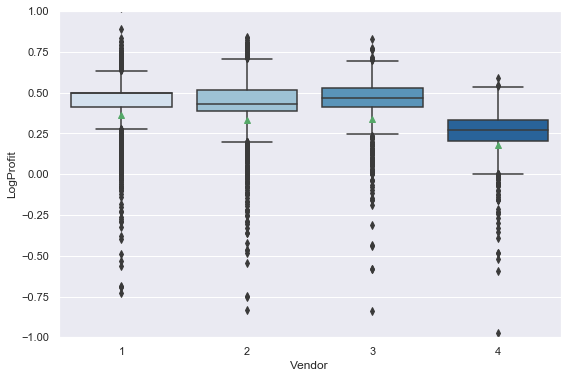

In [10]:
plt.figure(figsize=(9, 6))
sns.boxplot(x='Vendor', y='LogProfit', data=train, palette='Blues', showmeans=True)
plt.ylim(-1,1)

(0, 4)

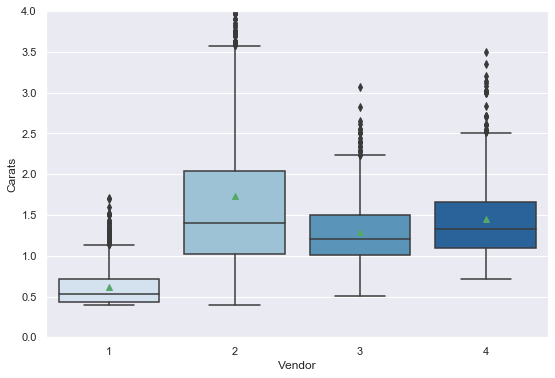

In [11]:
plt.figure(figsize=(9, 6))
sns.boxplot(x='Vendor', y='Carats', data=train, palette='Blues', showmeans=True)
plt.ylim(0,4)

In [12]:
# kmodes to do clustering for categorical variables

In [13]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=10, init='Cao', verbose=1)
res = km.fit(train[["Carats","Clarity","Color",'Fluroescence','Polish',"Regions","Shape","Symmetry"]])
labels = pd.Series(res.labels_, index = train.index)
train["trained_category"] = labels
trained_count = train.groupby(['Vendor','trained_category']).count().iloc[:,0:1]
for i in range(1,5):
    a = trained_count.loc[i]['Carats']/trained_count.loc[i].sum()[0]
    print(a[0])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 66, cost: 30263.0
Run 1, iteration: 2/100, moves: 0, cost: 30263.0
0.3597335307179867
0.44554149953717986
0.47377938517179025
0.44955044955044954


## Short problem 2
What is the relationship between Carat and Retail Price? Why do you think the relationship takes this form?
### my answer:
I drew pairplots of (carats, logcarats) against logRetail. The result shows that one can hardly tell about carats and retail price as carats increasing, retail price becomes disperse. However one can see carats and log retail has a nonlinear relationship like log function. Thus I plotted log carats against log retail that they have a more linear relationship, but still disperse around the line. I ran a simple linear regression and found that Rsquared is 79% which shows a good relationship that 1% increase in carats lead to 1.9% increase in log retail.

One thing to mention is that, even though the retail price is not so correlated with carats, I found that log carats is highly associated with log price where you can find in the boxplot. This helps the regression later.

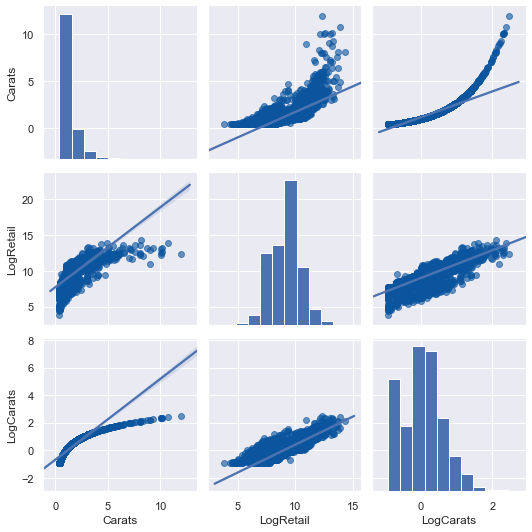

In [14]:

with sns.axes_style():
    g=sns.pairplot(train[['Carats', 'LogRetail', 'LogCarats']], kind='reg', 
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.6}})
plt.tight_layout()
plt.show()

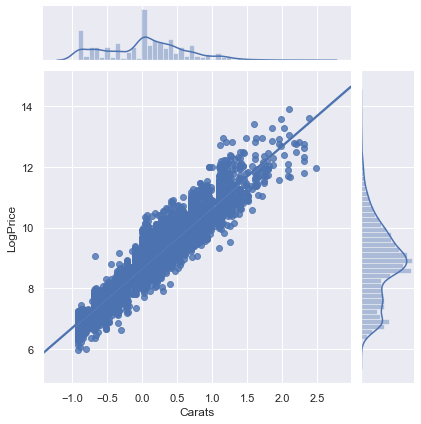

In [15]:
#for normality and non constant variance, use log transformed x and y
sns.jointplot(x=np.log(train["Carats"]), y=train["LogPrice"], kind="reg")
#plt.scatter(np.log(train["Carats"]), train["LogRetail"])

In [16]:
#1% increase in carats lead to 1.9% increase in logretail
rhs = sm.add_constant(np.log(train[["Carats"]].values))  #add a column of constant 1 left to the column  
res = sm.OLS(train["LogRetail"], rhs).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LogRetail   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 3.018e+04
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:05:52   Log-Likelihood:                -7155.6
No. Observations:                8050   AIC:                         1.432e+04
Df Residuals:                    8048   BIC:                         1.433e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0204      0.007   1368.842      0.000       9.007       9.033
x1             1.9452      0.011    173.710      0.000       1.923       1.967
==============================================================================
Omnibus:                     3767.723   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25487.973
Skew:                          -2.146   Prob(JB):                         0.00
Kurtosis:                      10.587   Cond. No.                         1.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analyze log return
In this section I wanted to see whether there are some attributes can determine the returns. After all high profits diamonds are what I seek for.

1. From the jointplot of carats and log return, I can see that for carats that are larger than a certain value, say 4.5, have most of positive return with only 3 negative returns. With that being said, the first rule I would follow is to buy the diamonds that have carats higher than 4.5. This rule is a little dangerous since two outliers have really bad returns.

2. Then I tried to extract some properties for carats lower than 3.5. One thing worth noticing is for 'Shape', 'Cushion' and 'ROUND' are two that have most positve returns. And also under low carats, Vendor4 has relatively lower return. Avoid buying diamonds from Vendor4. This is the second rule to consider offers.

3. Then I tried to extract some properties for carats higher than 4.5. Vendor2 is the only one providing the diamonds with positive return. This is the third rule that choose Vendor2 as primary seller.

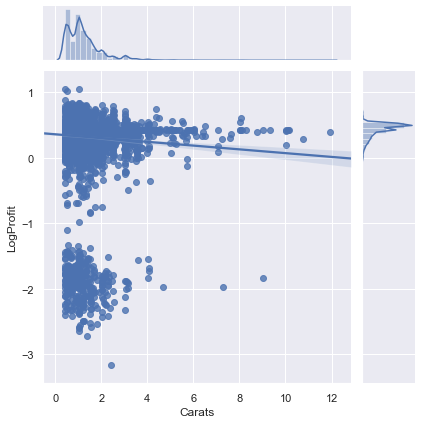

In [17]:
sns.jointplot(x=train['Carats'], y=(train["LogProfit"]), kind="reg")

In [18]:
lowCarats = train[train.Carats < 3.5]
highCarats = train[train.Carats > 4.5]

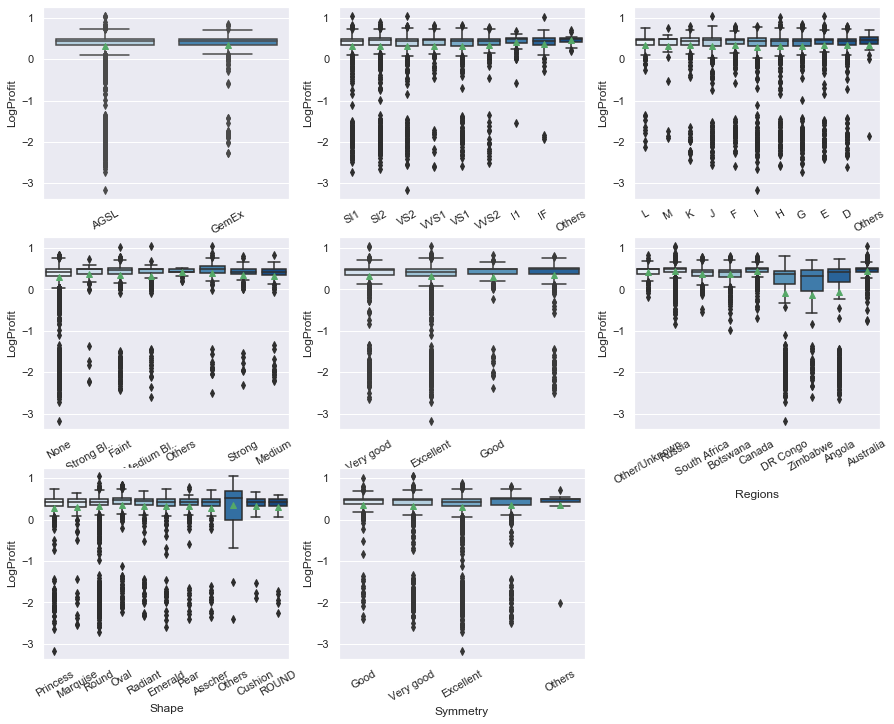

In [19]:
plt.figure(figsize=[15,12])
for i in range(1, 9):
    plt.subplot(3,3,i)
    ax = sns.boxplot(x = var[i-1], y = 'LogProfit', data = lowCarats, palette='Blues', showmeans=True)
    #plt.ylim(-1,1.2)
    plt.setp(ax.get_xticklabels(), rotation=30)

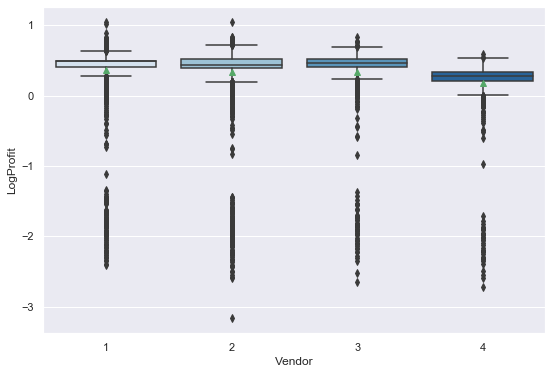

In [20]:
plt.figure(figsize=(9, 6))
sns.boxplot(x='Vendor', y='LogProfit', data=lowCarats, palette='Blues', showmeans=True)

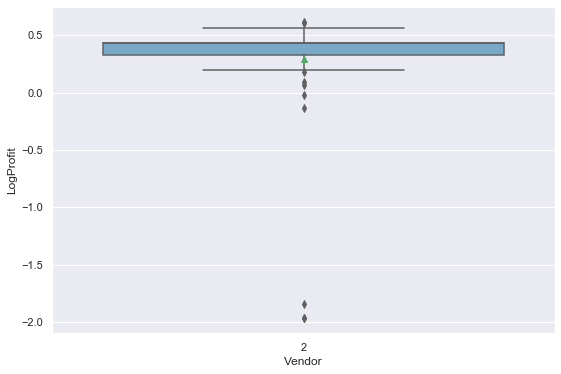

In [21]:
plt.figure(figsize=(9, 6))
sns.boxplot(x='Vendor', y='LogProfit', data=highCarats, palette='Blues', showmeans=True)

## One-hot encoding and train test split
In this section, I apply one-hot encoding to transform the categoical variables to dummy variables, and then split the dataset into 90% as train, 10% as test.


In [22]:
def OneHotSplit(train, y, size):
    variables = ['Clarity', 'Color', 'Polish','Fluroescence', 'Symmetry', 'Vendor']
    test = train[['win','LogPrice','LogRetail','LogCarats']]
    for var in variables:
        temp = pd.get_dummies(train[var])
        test = pd.concat([test, temp], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(test.iloc[:, 3:], 
                                                        test[[y]],test_size=size, random_state=24)
    return X_train, X_test, y_train, y_test

In [23]:
def OLS(X_train, X_test, y_train, y_test):
    rhs = sm.add_constant(X_train.values)
    X_test1 = sm.add_constant(X_test.values)
    reg = sm.OLS(y_train, rhs).fit()
    test_prediction = pd.DataFrame(reg.predict(X_test1), columns = ['predictions'], index = y_test.index)
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, test_prediction))
    print('R squared:', reg.rsquared)
    return test_prediction

In [24]:
def Plots(Y_test, y_pred, Y_train):
    plt.figure(figsize=[25,5])
    

    plt.subplot(1,3,1)
    plt.scatter(x=Y_test, y=y_pred, c='darkblue', alpha=0.6)
    plt.plot(Y_train, Y_train, color='cyan')

    plt.xlabel('Actual log prices ', fontsize=14)
    plt.ylabel('Prediced log prices ', fontsize=14)
    plt.title(f' (a) Actual vs Predicted log prices')
    
    
    plt.subplot(1,3,2)
    plt.scatter(x=y_pred, y=(Y_test - y_pred), c='darkblue', alpha=0.6)
    plt.xlabel('Predicted log prices ',)
    plt.ylabel('Residuals', )
    plt.title(' (b) Residuals vs Fitted Values')

    
    plt.subplot(1,3,3)
    resid_mean = round((Y_test - y_pred).mean(), 3)
    resid_skew = round((Y_test - y_pred).skew(), 3)
    print(resid_mean)
    sns.distplot((Y_test - y_pred), color='darkblue')
    plt.xlabel('Residuals')
    plt.title(f' Log price model:\n residuals Skew ({resid_skew}) Mean ({resid_mean})')
    plt.show()

### Linear regression on log price

Then I use linear regression taking log carats as input instead of carats, other inputs are 6 categorical variables. The R squared is pretty high, thus we must exmaine the residual to see whether some assumptions are failed. 

1. The predicted values are very close on one line. Some points above the line have large residuals.
2. The residual plots shows that there is no pattern where points are centered around 0. But still have several large residuals.
3. The distribution of the residual pretty much follows a normal distribution with 0 mean. This satisifies the regresion model assumptions
4. This model has MAE of 0.12, this is actually good for linear regression.

In [25]:
X_trainP, X_testP, y_trainP, y_testP = OneHotSplit(train, 'LogPrice', 0.1)

In [26]:
ols_prediction = OLS(X_trainP, X_testP, y_trainP, y_testP)

Mean Absolute Error (MAE): 0.12291035450276384
R squared: 0.9818265389214677


-0.006


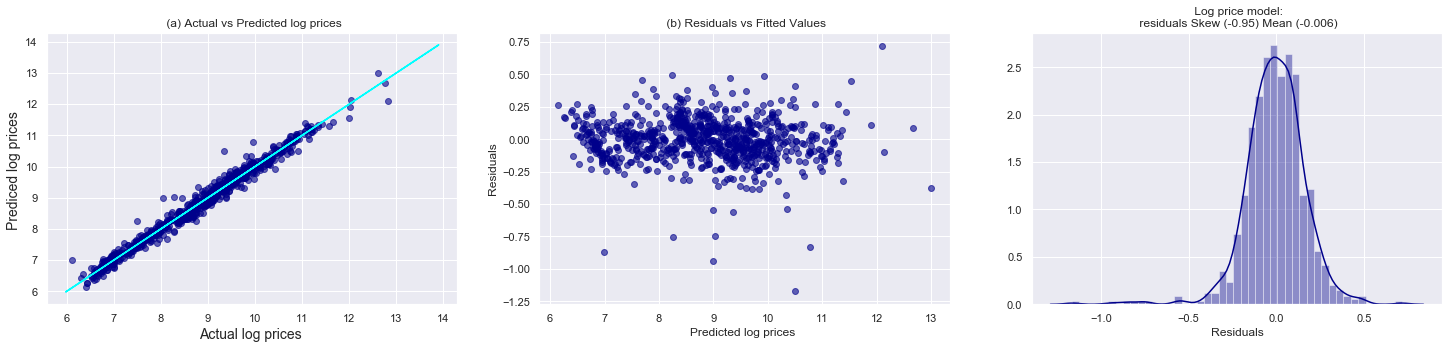

In [27]:
Plots(y_testP['LogPrice'], ols_prediction['predictions'], y_trainP)

### Random forest on LogPrice
Since there are a lot of dummy variables, I think of another method---random forest regression---as a pretty good statistical model. Using the same inputs as in linear regression, I obtained a better result than linear regression with MAE of 10%. Residual performance are similar as linear. However, random forest is better on the top-right area where for large carats, the price prediction would be more precise.

In [28]:
def RFR(X_train, X_test, y_train, y_test):    
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 24)
    rf.fit(X_train, y_train.values.ravel())
    predictions = rf.predict(X_test)
    predictions = pd.DataFrame(predictions, index = X_test.index, columns = ['predictions'])
    compare = pd.concat([predictions, y_test], axis=1)
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    
    
    return predictions

In [29]:
LogPricePred = RFR(X_trainP, X_testP, y_trainP, y_testP)

Mean Absolute Error (MAE): 0.10464254362122422
Root Mean Squared Error (RMSE): 0.16029807594644604


-0.012


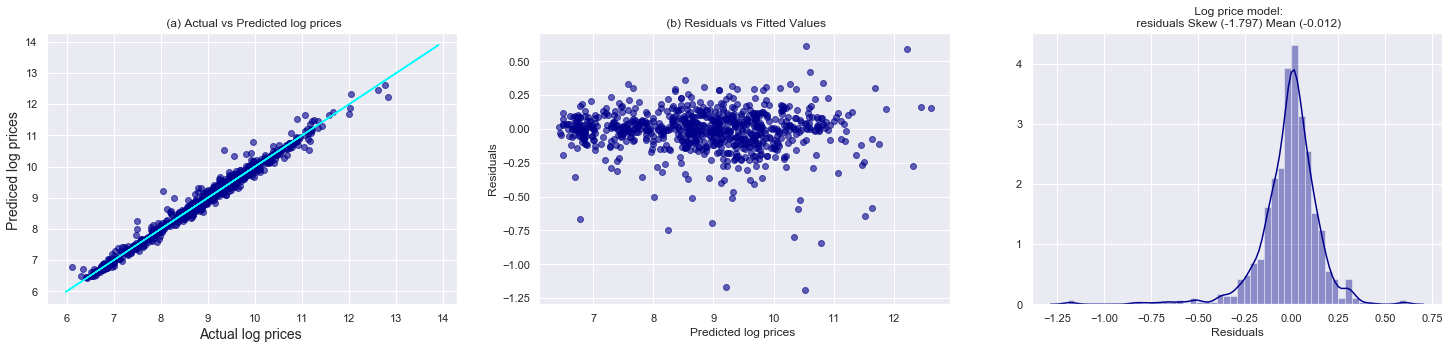

In [30]:
Plots(y_testP['LogPrice'], LogPricePred['predictions'], y_trainP)

### Random forest on LogRetail 

Apply same method to predict log retail price. The result is not satisfying as there are so many bias. This makes sense because factors that affect retail price are different from those of price, such as place, whether onsale, the way of selling. These factors are shown in the data. Thus it is inappropriate to conduct random forest model to predict retail price.

In [31]:
X_trainR, X_testR, y_trainR, y_testR = OneHotSplit(train, 'LogRetail', 0.1)

In [32]:
LogRetailPred = RFR(X_trainR, X_testR, y_trainR, y_testR)

Mean Absolute Error (MAE): 0.3253830308823589
Root Mean Squared Error (RMSE): 0.603691450645184


-0.003


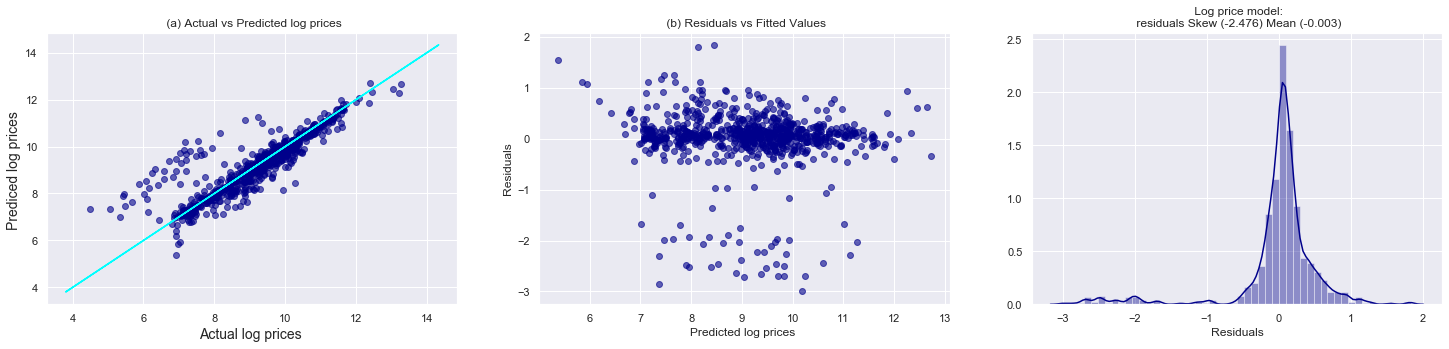

In [33]:
Plots(y_testR['LogRetail'], LogRetailPred['predictions'], y_trainR)

### logistic regression to predict the sign of return

I still wanted to find if the negative return can be predicted. If so, I can make offers easily without losing much money. I convert positive return to be 1, negative return to be 0, using logistic regression to calculate the probabilty of being postive return for a given data point. The result is shown below that it is bad with only half accuracy.

As conclusion, I think retail price is something that involves a random variable which is a very important key affecting retail. Since this kind of data is not available, using sophisticated model cannot predict

In [34]:
X_trainL, X_testL, y_trainL, y_testL = OneHotSplit(train, 'win', 0.1)

In [35]:
lr = LogisticRegression(class_weight='balanced',C=1e9, solver='newton-cg') 
lr.fit(X_trainL, y_trainL.values.ravel())
y_pred = lr.predict(X_testL)
confusion = confusion_matrix(y_testL, y_pred)
print(confusion)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_testL, y_testL)))
print(classification_report(y_testL, y_pred))
y_proba = lr.predict_proba(X_testL)

[[ 32  24]
 [351 398]]
Accuracy of logistic regression classifier on test set: 0.53
              precision    recall  f1-score   support

           0       0.08      0.57      0.15        56
           1       0.94      0.53      0.68       749

    accuracy                           0.53       805
   macro avg       0.51      0.55      0.41       805
weighted avg       0.88      0.53      0.64       805



## Calculate test profit
I use the random forest model to calculate the profit and the return of the test. Criteria are:
1. if predicted price is higher than price, accept the offer
2. if predicted price is lower than price, rejected

Also, I print out the big mistake that the predicted price is higher than retail price but true price is lower than retail price. This is the error I want to see what's the percentage of losing money which is 2%. And 5% of time is actually losing money. The result is satisfying that the return can be 25%. I searched online the average return for diamonds business is around 20%. This make sense.

In [36]:
def profit_cal(TestPred, y_test):
    y_retail = pd.DataFrame(train.loc[list(y_test.index)]['LogRetail'])
    CombinePred = pd.concat([TestPred, y_test, y_retail], axis=1)
    Lose1 = CombinePred[(CombinePred.predictions>CombinePred.LogRetail) & (CombinePred.LogPrice<CombinePred.LogRetail)]
    Lose2 = CombinePred[(CombinePred.predictions>CombinePred.LogRetail) & (CombinePred.LogPrice>CombinePred.LogRetail)]
    print("#The predicted price is higher than retail price but true price is lower than retail price = ", len(Lose1))
    print("#The predicted price is higher than retail price and true price is higher than retail price = ", len(Lose2))
    
    Profit = sum(np.where(CombinePred.predictions < CombinePred.LogPrice, 0, np.exp(CombinePred.LogRetail)
                      -np.exp(CombinePred.predictions)))
    Cost = sum(np.where(CombinePred.predictions < CombinePred.LogPrice, 0, np.exp(CombinePred.predictions)))
    #CombinePred['profit'] = np.where(CombinePred.predictions < CombinePred.LogPrice, 0, np.exp(CombinePred.LogRetail)
                      #-np.exp(CombinePred.predictions))
    
    
    print(Profit)
    print(Cost)
    print(Profit/Cost)
 

In [37]:
# random forest
profit_cal(LogPricePred, y_testP)

#The predicted price is higher than retail price but true price is lower than retail price =  18
#The predicted price is higher than retail price and true price is higher than retail price =  47
1343960.9582676406
5243204.041732374
0.25632436723244345


In [38]:
# linear regression 
profit_cal(ols_prediction, y_testP)

#The predicted price is higher than retail price but true price is lower than retail price =  17
#The predicted price is higher than retail price and true price is higher than retail price =  49
1596695.4034282635
6310374.5965717295
0.2530270396777568


## Rules:
1. buy all carats greater than 4.5 and from vendor 2
2. dont buy from vendor 4
3. if have more money, buy round and cushion diamonds until 5,000,000
4. round up to nearest multiple of 5

In [39]:
offer = preprocessing(offer)

offer['Polish']=offer[['Polish']].replace(to_replace = 'Fair', value = ' ')

columns_with_rare = ['Clarity', 'Color', 'Fluroescence', 'Symmetry']
for name in columns_with_rare:
    encode_rare(offer, name)

variables = ['Clarity', 'Color', 'Polish','Fluroescence', 'Symmetry', 'Vendor']
offer_data= offer[['LogCarats']]
for var in variables:
    temp = pd.get_dummies(offer[var])
    offer_data = pd.concat([offer_data, temp], axis = 1)

X_trainT, X_testT, y_trainT, y_testT = OneHotSplit(train, 'LogPrice', 0.000001)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 24)
rf.fit(X_trainT, y_trainT.values.ravel())
offer_predictions = rf.predict(offer_data)
offer_predictions = pd.DataFrame(offer_predictions, index = offer_data.index, columns = ['predictions'])

offer_list = pd.concat([offer[['Carats', 'Vendor', 'Shape', 'Regions']], np.exp(offer_predictions)], axis=1)

In [40]:
def upround(x):
    return 5*math.ceil(x/5)

In [41]:
batch1 = pd.DataFrame(offer_list[(offer_list['Carats']>4.5)][['predictions']].apply(upround, axis=1), 
                      columns = ['Offers'])
batch2 = pd.DataFrame(offer_list[offer_list['Shape'] == 'ROUND'][['predictions']].apply(upround, axis=1),
                      columns = ['Offers'])


In [42]:
remaining = 5000000 - batch1.Offers.sum() - batch2.Offers.sum()

In [43]:
batch3 = pd.DataFrame(offer_list[(offer_list['Shape'] == 'Cushion') & 
                                 (offer_list['Vendor'] == 2)][['predictions']].apply(upround, axis=1),
                      columns = ['Offers']).sort_values(by='Offers', ascending = False)

In [44]:
sum = 0
for i in range(len(batch3)):
    if (sum + batch3.iloc[i])[0] > remaining:
        pass
    else:
        print(batch3.iloc[i])
        sum += batch3.iloc[i]

Offers    17035
Name: 1863, dtype: int64
Offers    13235
Name: 1758, dtype: int64
Offers    3445
Name: 495, dtype: int64


In [45]:
batch3 = pd.DataFrame(np.array([17035, 13235, 3445]), index = [1863, 1758,495], columns = ['Offers'])

In [46]:
Offer_to_go = pd.concat([batch1,batch2,batch3]).sort_index()

In [47]:
original = pd.read_csv("offers.csv").drop(['Offers'], axis=1)
original = original.join(Offer_to_go)

In [48]:
original.to_csv('myOffers.csv')

## Summary
Throughout the analysis, I made 59 offers on diamonds which mostly focus on large carats diamonds and some specific diamonds. Since there is no strong pattern for retail price, and also no information on vendors willing price, the offers I made would be rejected. I raised Offers to the nearest multiple of 5. I did not add more on the price because I think the historical prices already show the least prices vendors can accept. That said, the predicted prices thus reflect they are already satisfying vendor's need. But this can be wrong for one or two diamonds.

The most influential factor for diamonds pricing is carats. In reality carat is used to considered as a standard. In my analysis, carat and price have strong Log-Log relationship. This helps to price a diamonds from a vendor.